In [84]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt

In [107]:
class CIR:
    def __init__(self, a, b, sigma):
        """
        Initialize the CIR model parameters.

        Parameters:
        a : float
            Long-term mean level * speed (mean reversion force).
        b : float
            Speed of mean reversion.
        sigma : float
            Volatility coefficient.
        """
        self.a = a
        self.b = b
        self.sigma = sigma

    def generate(self, r0, T, N, n):
        """
        Simulate CIR paths.

        Parameters:
        r0 : float
            Initial interest rate.
        T : float
            Total time horizon.
        N : int
            Number of time steps.
        n : int
            Number of simulation paths.

        Returns:
        r : ndarray
            Simulated short-rate paths of shape (N, n).
        """
        dt = T / N
        r = np.zeros((N, n))         # Matrix to hold all simulated paths
        r[0, :] = r0                 # Initial rate for all paths
        for i in range(1, N):
            sqrt_r = np.sqrt(r[i-1, :])
            dW = np.random.randn(n)  # Brownian increments
            dr = (self.a - self.b * r[i-1, :]) * dt + self.sigma * sqrt_r * np.sqrt(dt) * dW
            r[i, :] = np.maximum(r[i-1, :] + dr, 0)  # Ensure non-negativity
        return r

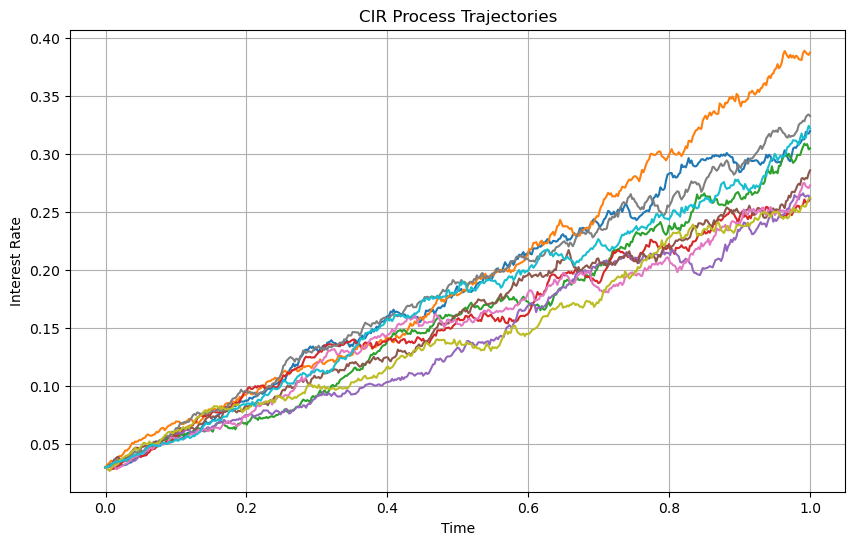

In [171]:
# Parameters
a = 0.3
b = 0.15
sigma = 0.1
r0 = 0.03
T = 1.0
N = 500
n = 10

# CIR model generation
cir = CIR(a, b, sigma)
trajectories = cir.generate(r0, T, N, n)

# Plotting
time = np.linspace(0, T, N)
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(time, trajectories[:, i], label=f'Trajectory {i+1}')
plt.title("CIR Process Trajectories")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()

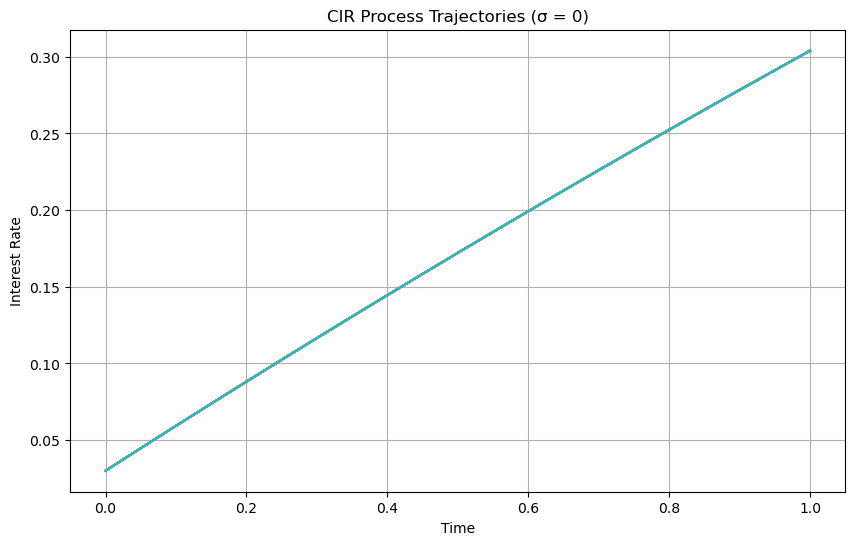

In [172]:
# Set volatility to zero (deterministic CIR dynamics)
sigma = 0

# CIR model generation
cir = CIR(a, b, sigma)
trajectories = cir.generate(r0, T, N, n)

# Plotting
time = np.linspace(0, T, N)
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(time, trajectories[:, i], label=f'Trajectory {i+1}')
plt.title("CIR Process Trajectories (σ = 0)")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()


## Maximum Likelihood estimation

https://dsp.vscht.cz/konference_matlab/MATLAB07/prispevky/kladivko_k/kladivko_k.pdf

\begin{equation}
\hat{a} =
\frac{
(N - 1) \sum_{i=1}^{N-1} r_{t_{i+1}} 
- \sum_{i=1}^{N-1} \frac{r_{t_{i+1}}}{r_{t_i}} \sum_{i=1}^{N-1} r_{t_i}
}{
\left( N^2 - 2N + 1 - \sum_{i=1}^{N-1} r_{t_i} \sum_{i=1}^{N-1} \frac{1}{r_{t_i}} \right) \Delta t
}
\end{equation}

\begin{equation}
\hat{b} =
\frac{
N^2 - 2N + 1 
+ \left( \sum_{i=1}^{N-1} r_{t_{i+1}} \right) \left( \sum_{i=1}^{N-1} \frac{1}{r_{t_i}} \right)
- \left( \sum_{i=1}^{N-1} r_{t_i} \right) \left( \sum_{i=1}^{N-1} \frac{1}{r_{t_i}} \right)
- (N - 1) \sum_{i=1}^{N-1} \frac{r_{t_{i+1}}}{r_{t_i}}
}{
\left( N^2 - 2N + 1 - \left( \sum_{i=1}^{N-1} r_{t_i} \right) \left( \sum_{i=1}^{N-1} \frac{1}{r_{t_i}} \right) \right) \Delta t
}
\end{equation}

The diffusion parameter initial estimatê σ is found as a standard deviation of residuals.

In [173]:
def a_hat(r, T):
    N = len(r)
    delta_t = T / N

    # Sum of r_{t_{i+1}} for i = 1 to N-1
    sum_r_next = sum(r[i+1] for i in range(N - 1))

    # Sum of r_{t_i} for i = 1 to N-1
    sum_r_current = sum(r[i] for i in range(N - 1))

    # Sum of r_{t_{i+1}} / r_{t_i} for i = 1 to N-1
    sum_r_next_over_r = sum(r[i+1] / r[i] for i in range(N - 1))

    # Sum of 1 / r_{t_i} for i = 1 to N-1
    sum_1_over_r = sum(1 / r[i] for i in range(N - 1))

    numerator = (N - 1) * sum_r_next - sum_r_next_over_r * sum_r_current
    denominator = (N**2 - 2*N + 1 - sum_r_current * sum_1_over_r) * delta_t

    return numerator / denominator



In [179]:
def b_hat(r, T):
    r = np.array(r)
    N = len(r)
    delta_t = T / N

    # r_{t_i} for i = 1 to N-1
    r_t_i = r[:-1]

    # r_{t_{i+1}} for i = 1 to N-1
    r_t_i1 = r[1:]

    # Sum of r_{t_i}
    sum_r_t_i = np.sum(r_t_i)

    # Sum of r_{t_{i+1}}
    sum_r_t_i1 = np.sum(r_t_i1)

    # Sum of 1 / r_{t_i}
    sum_inv_r_t_i = np.sum(1 / r_t_i)

    # Sum of r_{t_{i+1}} / r_{t_i}
    sum_r_t_i1_over_r_t_i = np.sum(r_t_i1 / r_t_i)

    numerator = (
        (N - 1) ** 2
        + sum_r_t_i1 * sum_inv_r_t_i
        - sum_r_t_i * sum_inv_r_t_i
        - (N - 1) * sum_r_t_i1_over_r_t_i
    )

    denominator = (
        ((N - 1) ** 2 - sum_r_t_i * sum_inv_r_t_i) * delta_t
    )

    return numerator / denominator


In [183]:
def sigma_hat(a_hat, b_hat, r, T):
    import numpy as np

    r = np.asarray(r)
    N = len(r)
    dt = T / N

    r_i = r[:-1]      # r_{t_i}
    r_next = r[1:]    # r_{t_{i+1}}

    # Compute the deterministic drift part: (a - b * r_i) * dt
    drift = (a_hat - b_hat * r_i) * dt

    # Difference between actual and expected values (residuals)
    numerators = r_next - r_i - drift

    # Denominator for standardization using sqrt(r_i)
    denominators = np.sqrt(r_i)

    # Standardized residuals
    residuals = numerators / denominators

    # Estimate of sigma^2 based on residual variance
    sigma_squared = np.sum(residuals**2) / (len(residuals) * dt)

    return np.sqrt(sigma_squared)

In [184]:
a = 0.8
b = 0.15
sigma = 0.1
r0 = 0.03
T = 1.0
N = 500

In [186]:
# Instantiate the CIR model with given parameters
model = CIR(a, b, sigma)

# Generate n simulated paths (e.g., n = 1 here)
r_paths = model.generate(r0, T, N, n)

# Extract the first (and only) trajectory: a vector of size N
r = r_paths[:, 0]

# Estimate model parameters from the simulated trajectory
a_est = a_hat(r, T)
b_est = b_hat(r, T)
sigma_est = sigma_hat(a_est, b_est, r, T)

# Display results
print(f"{'Parameter':<20} {'True':>10} {'Estimated':>10}")
print(f"{'-'*40}")
print(f"{'a':<20} {a:10.5f} {a_est:10.5f}")
print(f"{'b':<20} {b:10.5f} {b_est:10.5f}")
print(f"{'sigma':<20} {sigma:10.5f} {sigma_est:10.5f}")

Parameter                  True  Estimated
----------------------------------------
a                       0.80000    0.86746
b                       0.15000    0.54710
sigma                   0.10000    0.09811


La calibration ne marche pas bien pour b. Est-ce d'implémentation (?)